In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import os
import cv2
import joblib
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

In [2]:
# Define dataset path
test_dir = "Testing"  

# Define class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [3]:
# Load pre-trained models without the classification head
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

C:\Users\chand\AppData\Local\Temp\ipykernel_19452\2050749787.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


In [4]:
# Load trained SVM classifiers
svm_mobilenet = joblib.load("svm_mobilenetv2.pkl")
svm_efficientnet = joblib.load("svm_efficientnetb0.pkl")
svm_resnet = joblib.load("svm_resnet50.pkl")

In [5]:
# Function to randomly select a test image
def get_random_test_image(test_dir):
    # Choose a random class folder (glioma, meningioma, notumor, pituitary)
    random_class = random.choice(os.listdir(test_dir))

    # Get a list of images from that class
    class_path = os.path.join(test_dir, random_class)
    image_list = os.listdir(class_path)

    # Choose a random image from the selected class
    random_image = random.choice(image_list)
    image_path = os.path.join(class_path, random_image)

    print(f"Selected Image: {image_path}")  # Print selected image path
    return image_path

In [6]:
# Function to preprocess image for each model
def preprocess_image(image_path, model_type):
    img = cv2.imread(image_path)

    if img is None:
        raise FileNotFoundError(f"Error: Image not found at {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying
    img_resized = cv2.resize(img, (224, 224))  # Default size for MobileNetV2 and ResNet50

    if model_type == "mobilenet":
        img_processed = mobilenet_preprocess(img_resized)
    elif model_type == "efficientnet":
        img_resized = cv2.resize(img, (240, 240))  # Resize for EfficientNetB0
        img_processed = efficientnet_preprocess(img_resized)
    elif model_type == "resnet":
        img_processed = resnet_preprocess(img_resized)

    img_processed = np.expand_dims(img_processed, axis=0)  # Add batch dimension
    return img_processed, img_resized  # Return processed image & resized image for display

Selected Image: Testing\meningioma\Te-me_0115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


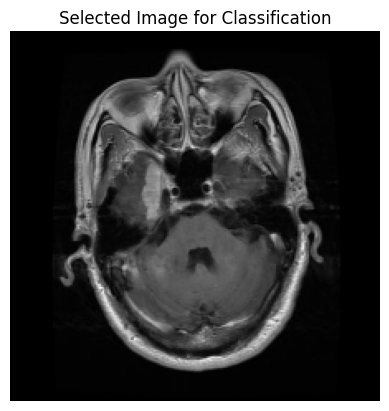

Predictions for selected image: Testing\meningioma\Te-me_0115.jpg
MobileNetV2 Prediction: meningioma
EfficientNetB0 Prediction: meningioma
ResNet50 Prediction: meningioma


In [7]:
# Function to extract features using a given model
def extract_features(image_path, model, model_type):
    img_processed, img_resized = preprocess_image(image_path, model_type)
    features = model.predict(img_processed)
    return features.flatten(), img_resized  # Return features and resized image

# Function to classify an image using all three models
def classify_image():
    # Get a random test image
    image_path = get_random_test_image(test_dir)

    # Extract features from all models
    features_mobilenet, img_resized = extract_features(image_path, mobilenet_model, "mobilenet")
    features_efficientnet, _ = extract_features(image_path, efficientnet_model, "efficientnet")
    features_resnet, _ = extract_features(image_path, resnet_model, "resnet")

    # Predict class using SVM classifiers
    pred_mobilenet = svm_mobilenet.predict([features_mobilenet])[0]
    pred_efficientnet = svm_efficientnet.predict([features_efficientnet])[0]
    pred_resnet = svm_resnet.predict([features_resnet])[0]

    # Display the image
    plt.imshow(img_resized)
    plt.axis("off")
    plt.title("Selected Image for Classification")
    plt.show()

    # Print classification results
    print(f"Predictions for selected image: {image_path}")
    print(f"MobileNetV2 Prediction: {class_labels[pred_mobilenet]}")
    print(f"EfficientNetB0 Prediction: {class_labels[pred_efficientnet]}")
    print(f"ResNet50 Prediction: {class_labels[pred_resnet]}")

# Run classification on a random test image
classify_image()